In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset

from desc.backend import jnp
from desc.compute import compute_rotational_transform
from desc.equilibrium import Equilibrium
from desc.grid import ConcentricGrid, LinearGrid
import desc.io
from desc.compute import data_index
from desc.transform import Transform
from desc.plotting import plot_1d
from desc.profiles import PowerSeriesProfile
from desc.vmec import VMECIO

np.set_printoptions(precision=3, floatmode="fixed")
jnp.set_printoptions(precision=3, floatmode="fixed")

DESC version 0.5.1+106.g8183adc.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 9.47 GB available memory


## Visualizing different grids

In [3]:
rng = np.random.default_rng()
L = rng.integers(low=1, high=30)
M = rng.integers(low=1, high=30)
N = rng.integers(low=1, high=30)
NFP = rng.integers(low=1, high=30)
sym = True if rng.integers(2) > 0 else False
random_grid = ConcentricGrid(L=L, N=N, M=M, NFP=NFP, sym=sym)

In [4]:
def print_grid(grid, stop=None, quantity=None):
    """
    Parameters
    ----------
    grid
        Prints nodes and spacing.
    stop : int
        Max number of nodes to print. Defaults to entire grid.
    quantity : ndarray
        A quantity to print alongside the grid. i.e. data["iota"]
    """
    assert (
        len(grid.nodes) // grid.num_zeta
        == jnp.where(~jnp.isclose(grid.nodes[:, 2], 0))[0][0]
    )
    print(grid.L, grid.M, grid.N, grid.NFP, grid.sym, grid.node_pattern)
    print(grid.num_rho, grid.num_theta, grid.num_zeta)
    print("nodes", "             ", "spacing")
    if stop is None:
        stop = len(grid.nodes)
    if quantity is None:
        for i, e in enumerate(zip(grid.nodes, grid.spacing)):
            a, b = e
            print(a, b)
            if i > stop:
                break
    else:
        for i, e in enumerate(zip(grid.nodes, grid.spacing, quantity)):
            a, b, c = e
            print(a, b, c)
            if i > stop:
                break

(<Figure size 384x384 with 1 Axes>,
 <PolarAxesSubplot:title={'center':'LinearGrid, $L=10$, $M=1, pattern: linear$'}>)

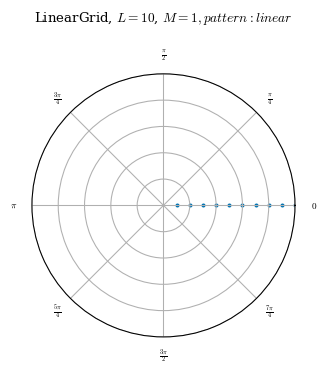

In [5]:
# print_grid(random_grid, stop=50)
desc.plotting.plot_grid(LinearGrid(rho=jnp.linspace(1 / 10, 1, 10)))

In [6]:
def get_concentric_grid(eq):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.

    Returns
    -------
    ConcentricGrid
        Concentric grid used by the given equilibrium.
    """
    return ConcentricGrid(
        L=eq.L_grid,
        M=eq.M_grid,
        N=eq.N_grid,
        NFP=1,  # to avoid known grid bug
        sym=False,
        node_pattern=eq.node_pattern,
    )


def get_vmec_plot(name):
    """
    Parameters
    ----------
    name : str
        Name of the equilibrium.

    Returns
    -------
    rho : ndarray
        rho values. x-axis of plot.
    iota : ndarray
        iota. y-axis of plot.
    """
    f = Dataset("edu-vmec/input-current/wout_" + name + ".nc")
    iota = jnp.asarray(f.variables["iotaf"])
    rho = jnp.sqrt(f.variables["phi"] / np.array(f.variables["phi"])[-1])
    return rho, iota


def plot(x, y, prepend_title):
    """
    Parameters
    ----------
    x : ndarray
        plot x-axis.
    y : ndarray
        plot y-axis. will make multiple plots if y.ndim > 1
    prepend_title : str
        string to prepend to plot title
    """
    dot_size = 5 if len(x) > 64 else 10
    y = np.atleast_2d(y)
    fig, ax = plt.subplots(ncols=y.shape[0], figsize=(y.shape[0] * 8, 5))
    ax = np.atleast_1d(ax)

    for i in range(y.shape[0]):
        append = " " + str(i) + " derivative wrt rho"
        ax[i].scatter(x, y[i, :], s=dot_size)
        ax[i].plot(x, y[i, :])
        ax[i].set(
            yscale="symlog",
            xlabel=r"$\rho$",
            ylabel="iota" + append,
            title=prepend_title + " iota" + append,
            facecolor="white",
        )
        ax[i].grid()


def plot_overlay(x, y, prepend_title, x2, y2, prepend_title_2, dpi=200, log=False):
    """
    Parameters
    ----------
    x : ndarray
        plot x-axis.
    y : ndarray
        plot y-axis. will make multiple plots if y.ndim > 1
    prepend_title : str
        string to prepend to plot title
    """
    dot_size = 2 if len(x) > 128 else 5
    y = np.atleast_2d(y)
    y2 = np.atleast_2d(y2)
    fig, ax = plt.subplots(dpi=dpi)
    ax = np.atleast_1d(ax)

    for i in range(y.shape[0]):
        append = " " + str(i) + " derivative wrt rho"
        ax[i].scatter(x, y[i, :], s=dot_size, label=prepend_title)
        ax[i].plot(x, y[i, :])
        ax[i].scatter(x2, y2[i, :], s=dot_size, label=prepend_title_2)
        ax[i].plot(x2, y2[i, :])
        ax[i].set(
            yscale="log" if log else "linear",
            xlabel=r"$\rho$",
            ylabel="iota" + append,
            title="iota" + append,
            facecolor="white",
        )
        ax[i].grid()
    fig.legend()

16 9 15 3 True jacobi
9 44 31
nodes               spacing
[0.036 2.094 0.000] [ 0.135 10.976  0.118] -0.0
[0.118 0.698 0.000] [0.175 3.659 0.118] -0.0
[0.118 2.793 0.000] [0.175 3.659 0.118] -0.0
[0.237 0.349 0.000] [0.230 1.829 0.118] -0.0
[0.237 1.396 0.000] [0.230 1.829 0.118] -0.0
[0.237 2.443 0.000] [0.230 1.829 0.118] -0.0
[0.382 0.262 0.000] [0.263 1.372 0.118] -0.0
[0.382 1.047 0.000] [0.263 1.372 0.118] -0.0
[0.382 1.833 0.000] [0.263 1.372 0.118] -0.0

16 9 15 3 True jacobi
9 44 31
nodes               spacing
[0.036 2.094 0.000] [ 0.135 10.976  0.118] -396.21557733768833
[0.118 0.698 0.000] [0.175 3.659 0.118] -399.44574749599053
[0.118 2.793 0.000] [0.175 3.659 0.118] -404.14754831624975
[0.237 0.349 0.000] [0.230 1.829 0.118] -409.8603035512982
[0.237 1.396 0.000] [0.230 1.829 0.118] -416.02473345967684
[0.237 2.443 0.000] [0.230 1.829 0.118] -422.0374078387646
[0.382 0.262 0.000] [0.263 1.372 0.118] -427.30978698146316
[0.382 1.047 0.000] [0.263 1.372 0.118] -431.325897447

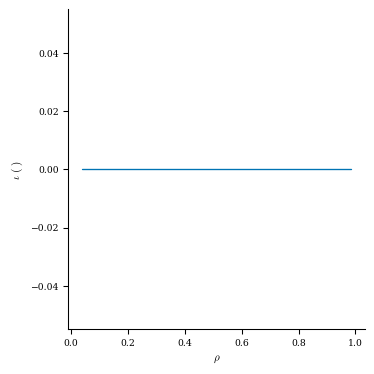

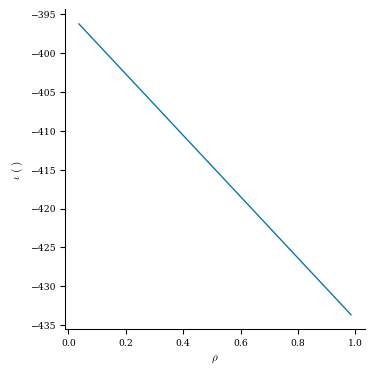

In [7]:
zero_current = PowerSeriesProfile(params=[0], modes=[0], grid=random_grid)
finite_current = PowerSeriesProfile(params=[1e7], modes=[2], grid=random_grid)
zero_current_torus = Equilibrium(current=zero_current)
finite_current_torus = Equilibrium(current=finite_current)

grid_1d = LinearGrid(rho=random_grid.nodes[random_grid.unique_rho_indices, 0])
plot_1d(zero_current_torus, "iota", grid=grid_1d)
print_grid(
    random_grid,
    stop=10,
    quantity=zero_current_torus.compute("iota", grid=grid_1d)["iota"],
)
print()
plot_1d(finite_current_torus, "iota", grid=grid_1d)
print_grid(
    random_grid,
    stop=10,
    quantity=finite_current_torus.compute("iota", grid=grid_1d)["iota"],
)

## Functions to compute iota using bootstrap method.
Let's call this testing method the bootstrap method: where we use the current computed on an equilibrium solved from an input with iota coefficients to recompute iota with the new method.

In [8]:
def get_transform(eq, grid):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.
    grid : ConcentricGrid
        Concentric grid used by the given equilibrium.

    Returns
    -------
    Transform
         R_transform, Z_transform, L_transform of the given equilibrium.
    """
    r_derivs = jnp.vstack(
        (
            data_index["sqrt(g)_rr"]["R_derivs"],
            data_index["iota"]["R_derivs"],
        )
    )
    l_derivs = jnp.vstack(
        (
            data_index["lambda_t"]["L_derivs"],
            data_index["lambda_rt"]["L_derivs"],
            data_index["lambda_rrt"]["L_derivs"],
            data_index["lambda_z"]["L_derivs"],
            data_index["lambda_rz"]["L_derivs"],
            data_index["lambda_rrz"]["L_derivs"],
            data_index["iota"]["L_derivs"],
        )
    )
    R_transform = Transform(grid, eq.R_basis, derivs=r_derivs, build=True)
    Z_transform = Transform(grid, eq.Z_basis, derivs=r_derivs, build=True)
    L_transform = Transform(grid, eq.L_basis, derivs=l_derivs, build=True)
    return R_transform, Z_transform, L_transform


def get_toroidal_current(eq, grid):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.
    grid : ConcentricGrid
        The grid for the power series profile.

    Returns
    -------
    current : ndarray
        The toroidal current in tesla-meters at each unique rho surface of the given equilibrium.
    """
    current = np.empty(grid.num_rho)
    for i, r in enumerate(grid.nodes[grid.unique_rho_indices, 0]):
        data = eq.compute("I", grid=LinearGrid(rho=np.atleast_1d(r)))
        current[i] = data["I"]
    assert jnp.isfinite(current).all()
    print(eq)
    print(current)
    return current


def get_iota(eq):
    """
    Get iota using the current from data["I"] as constraint.
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.

    Returns
    -------
    iota : ndarray
        The computed rotational transform.
    """
    grid = get_concentric_grid(eq)
    transform = get_transform(eq, grid)
    return compute_rotational_transform(
        eq.R_lmn,
        eq.Z_lmn,
        eq.L_lmn,
        i_l=None,  # random value, won't be used
        c_l=None,  # random value, won't be used
        Psi=eq.Psi,
        R_transform=transform[0],
        Z_transform=transform[1],
        L_transform=transform[2],
        iota=None,  # to force compute with new function
        current=1,  # random value, won't be used
        current_from_solved_eq=get_toroidal_current(eq, grid),
    )

/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(


Equilibrium at 0x7f4134162b50 (L=26, M=13, N=0, NFP=1.0, sym=1, spectral_indexing=fringe)
[-2.380e-06 -2.653e-05 -1.158e-04 -3.345e-04 -7.631e-04 -1.491e-03
 -2.607e-03 -4.192e-03 -6.306e-03 -8.977e-03 -1.220e-02 -1.591e-02
 -2.002e-02 -2.438e-02 -2.881e-02 -3.313e-02 -3.716e-02 -4.073e-02
 -4.372e-02 -4.605e-02 -4.769e-02 -4.866e-02 -4.907e-02 -4.905e-02
 -4.879e-02 -4.846e-02 -4.822e-02]


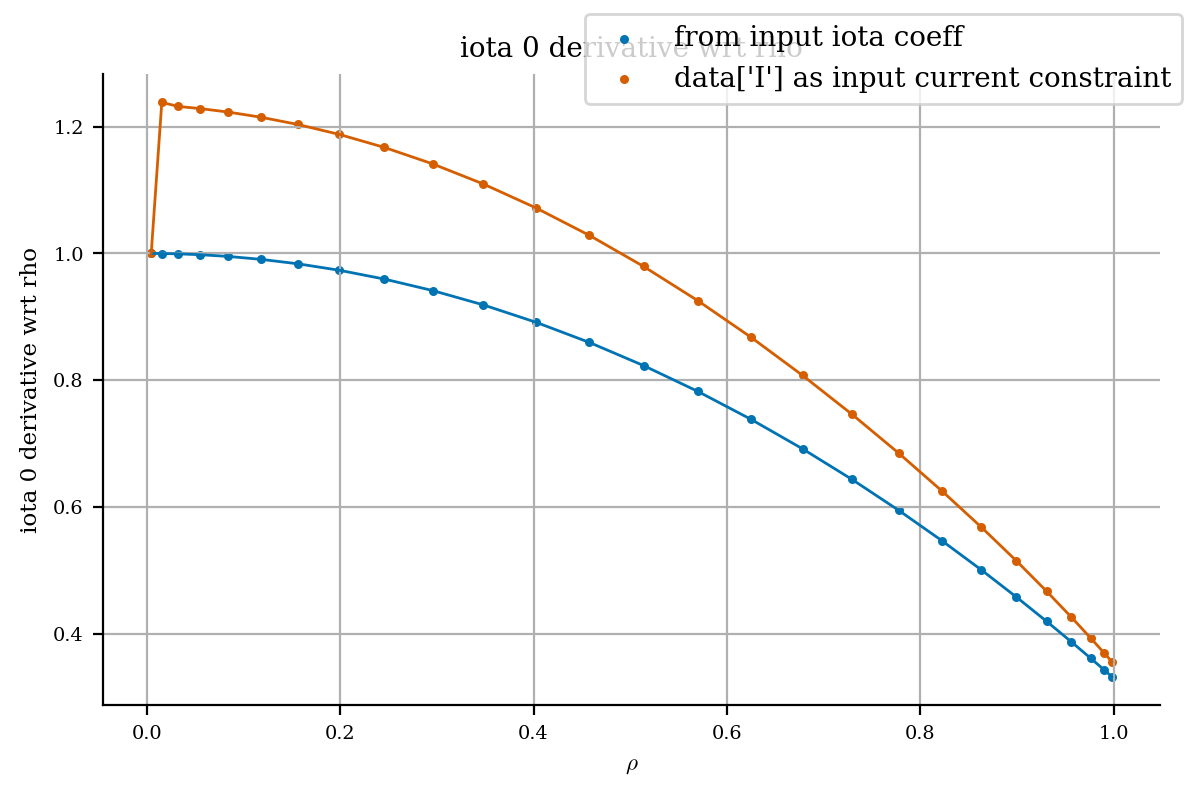

In [9]:
eq = desc.io.load("../examples/DESC/" + "DSHAPE" + "_output.h5")[-1]
conc_grid = get_concentric_grid(eq)
rho = conc_grid.nodes[conc_grid.unique_rho_indices, 0]
iota_from_coef = eq.compute("iota", grid=conc_grid)["iota"][
    conc_grid.unique_rho_indices
]
iota = get_iota(eq)["iota"][conc_grid.unique_rho_indices]
plot_overlay(
    rho,
    iota_from_coef,
    "from input iota coeff",
    rho,
    iota
    / (
        2 * jnp.pi
    ),  # really don't think this factor of 2pi should be here, but it makes plots look closer.
    "data['I'] as input current constraint",
)

## compute iota from equilibrium solved with current coeff in input file

In [10]:
# some of these the solver just exits early saying no nested surfaces.
# This can either mean
# 1. the input current profile does not lend itself to nested surfaces.
# 2. the rotational transform function is being computed incorrectly, messing up force balance
# 3. that thing Dario mentioned where DIII-D was a non-fixed surface boundary.
names = (
    "DSHAPE",
    "SOLOVEV",
    "DIII-D",
    "HELIOTRON",
    "AXISYM",
)

In [11]:
# don't think edu-vmec has the correct variable naming scheme for this
# see if boundary shapes are different
# for name in names:
#     VMECIO.plot_vmec_comparison(
#         equil="../examples/DESC/input-current/" + name + "_output.h5",
#         vmec_data="edu-vmec/input-current/wout_" + name + ".nc",
#     )

/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_iota' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_iota' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_iota' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_iota' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_iota' was not loaded.
  warnings.warn(


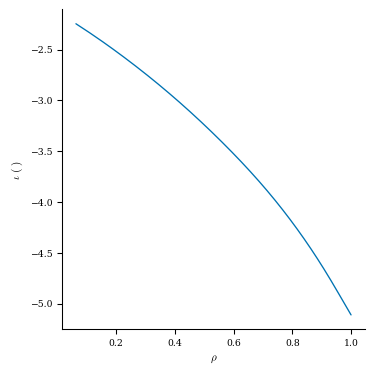

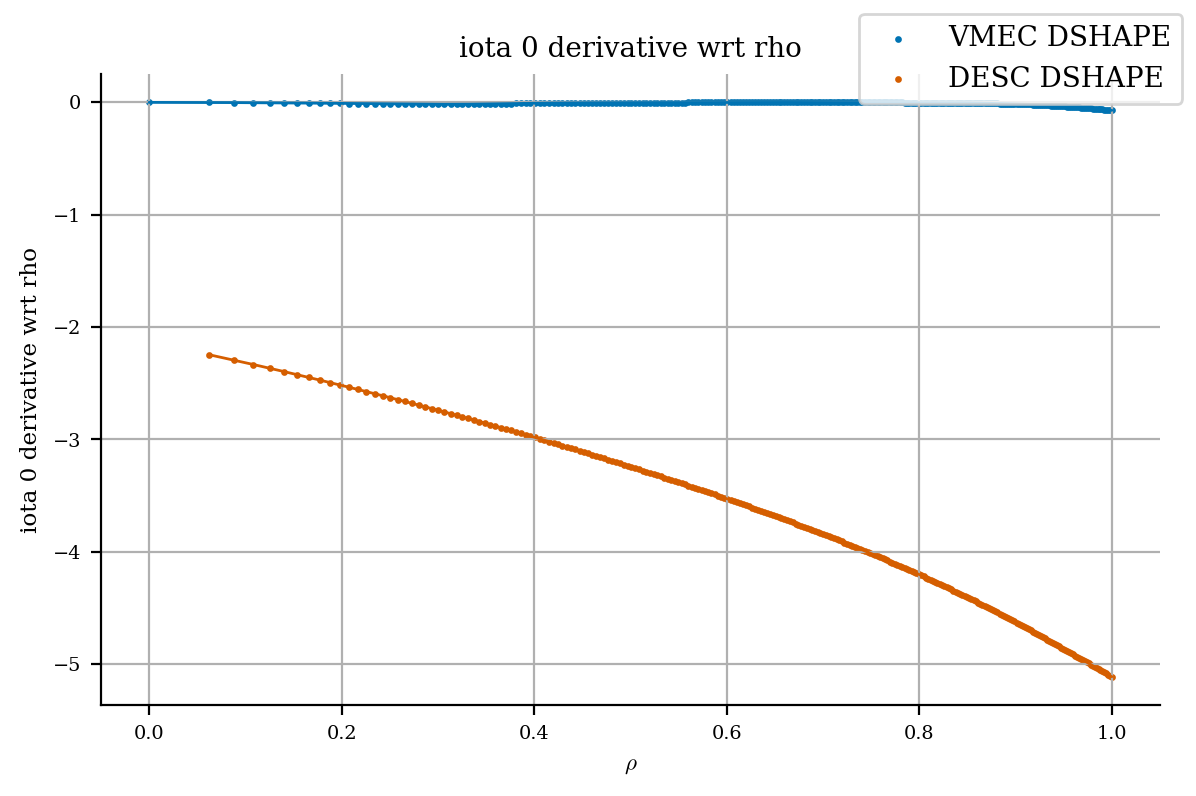

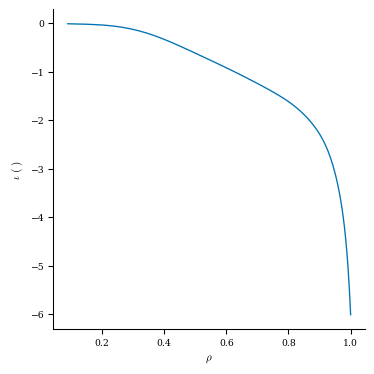

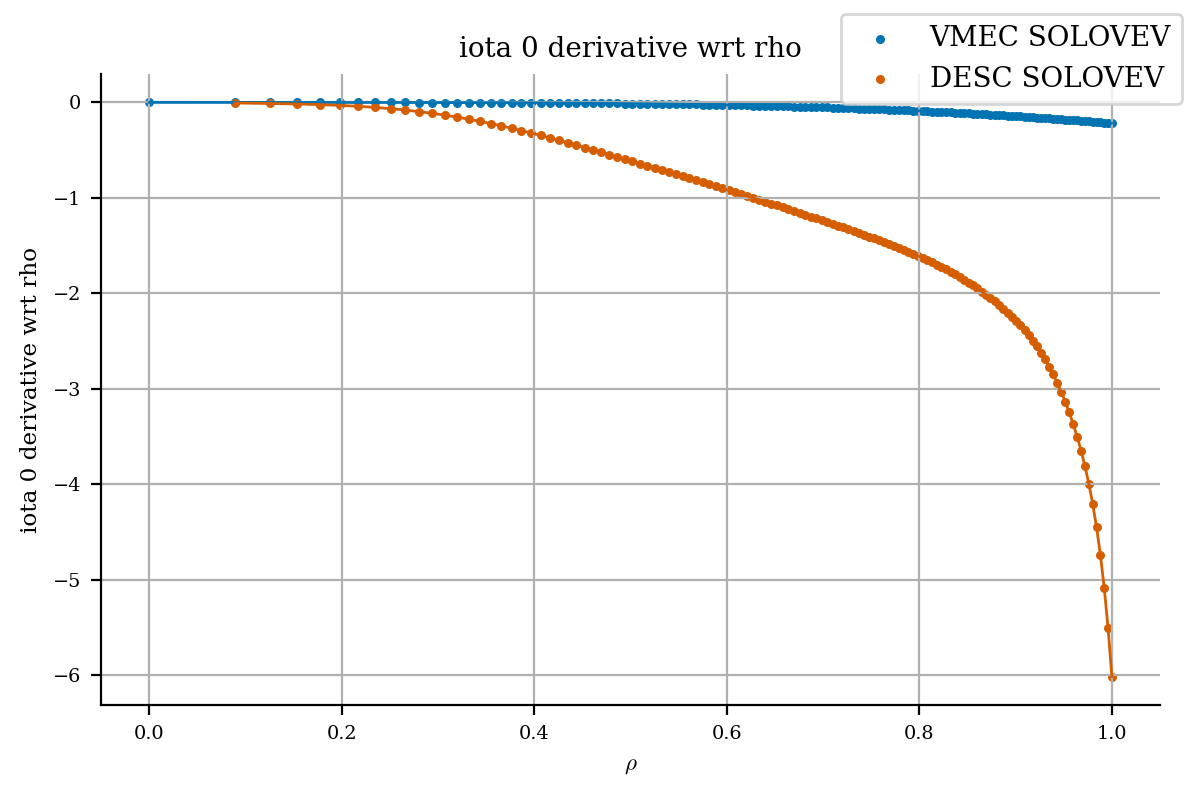

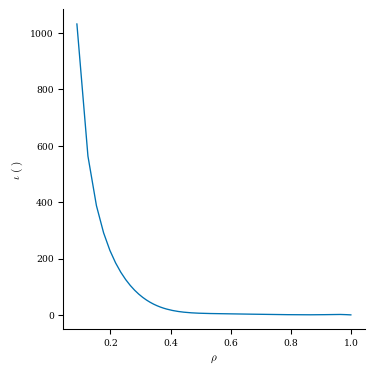

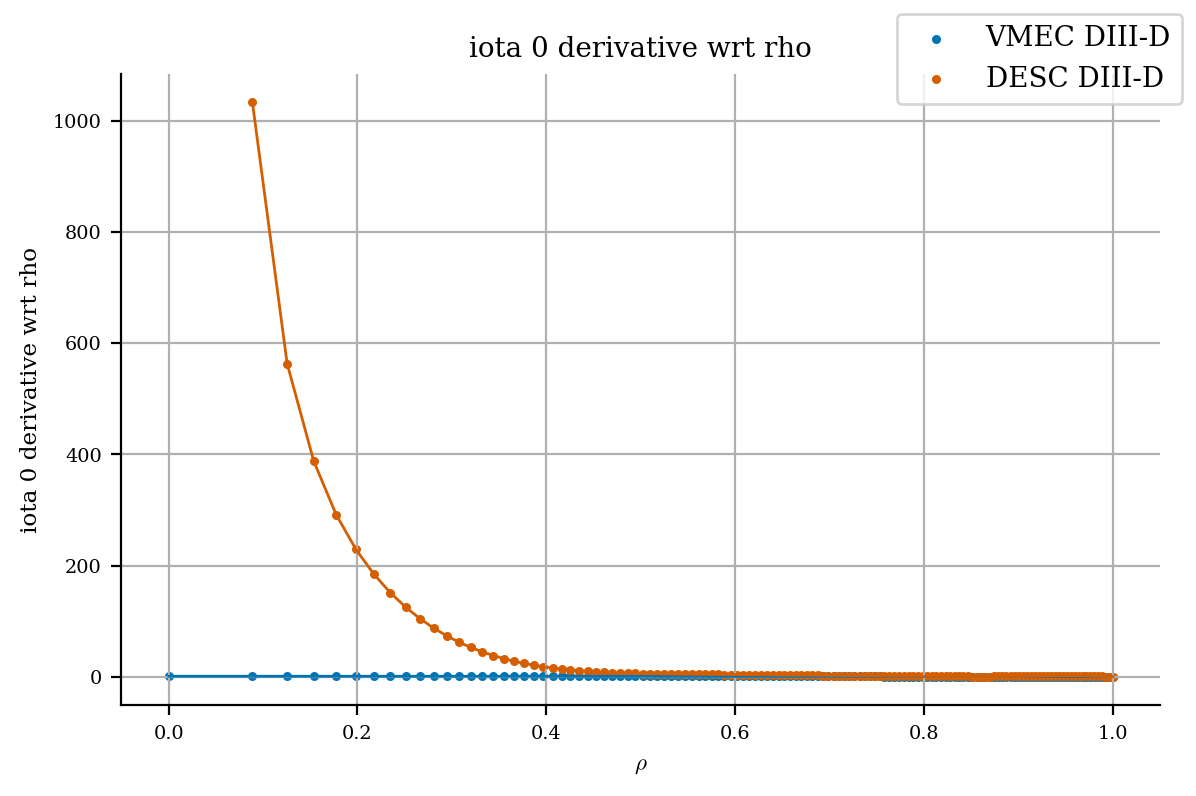

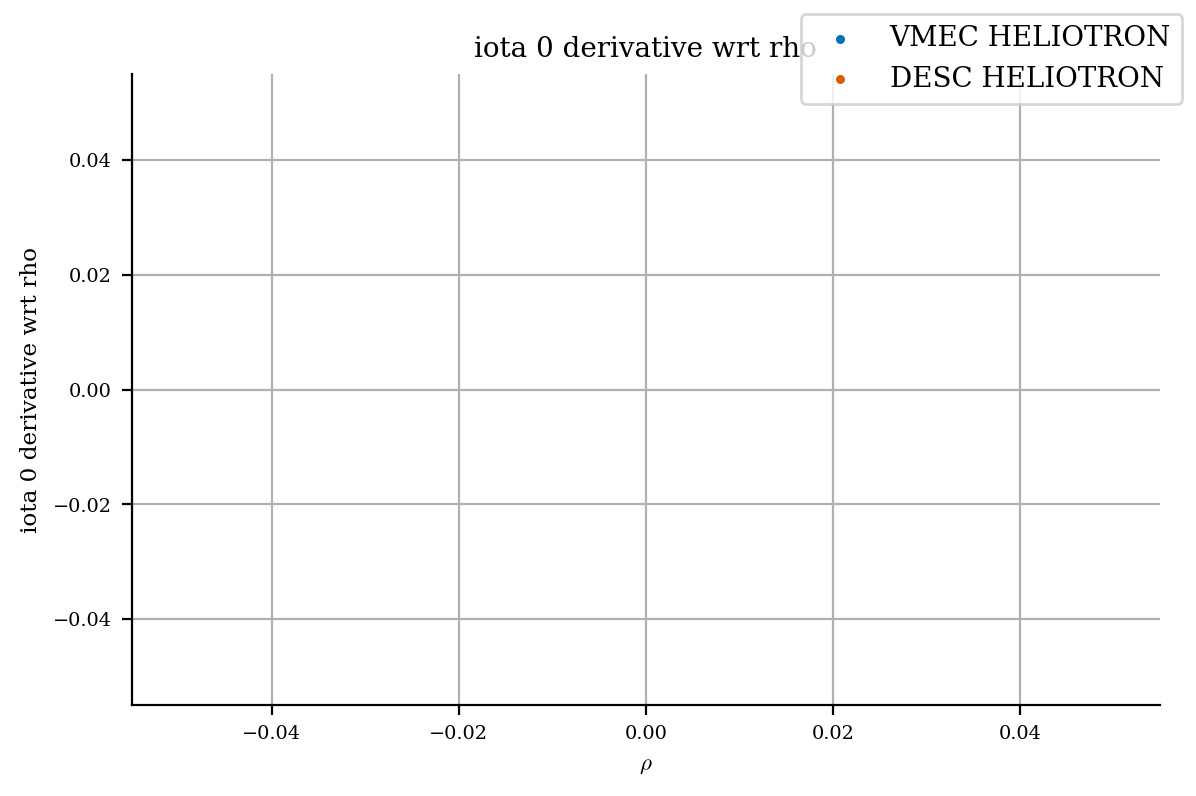

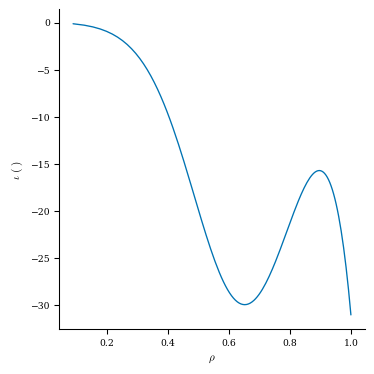

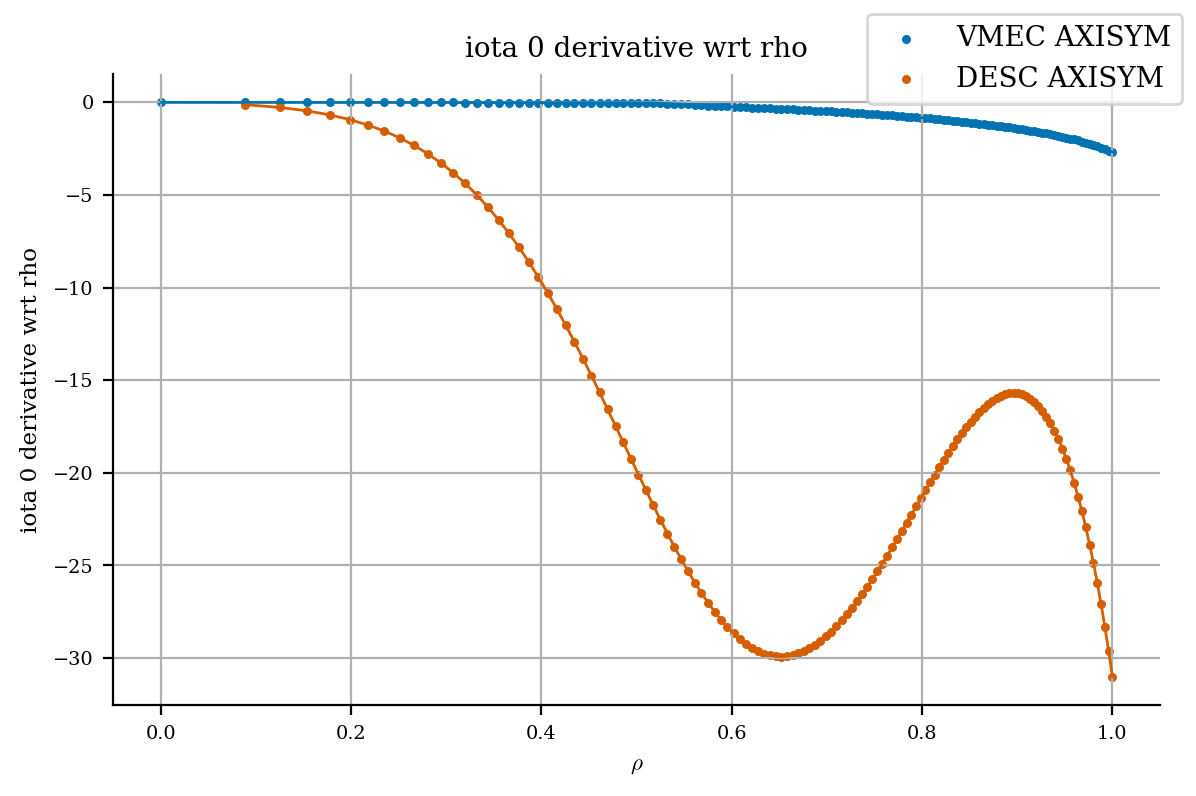

In [12]:
for name in names:
    rho, iota = get_vmec_plot(name)
    grid = LinearGrid(rho=rho)
    eq = desc.io.load("../examples/DESC/input-current/" + name + "_output.h5")[-1]
    plot_1d(eq, "iota", grid=grid)
    iota_desc = eq.compute("iota", grid=grid)["iota"]
    plot_overlay(
        rho,
        iota,
        "VMEC " + name,
        rho,
        iota_desc,
        "DESC " + name,
    )